https://colab.research.google.com/drive/1pOawwxLYvrZq2I3OJRq1cCQ9FUOgbA5f

In [2]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz

--2019-10-02 18:08:13--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225573614 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz.1’

genres.tar.gz.1     100%[===================>]   1.14G   801KB/s    in 21m 34s 

2019-10-02 18:29:47 (925 KB/s) - ‘genres.tar.gz.1’ saved [1225573614/1225573614]



In [0]:
!tar xzf genres.tar.gz.1

In [4]:
!ls

genres	genres.tar.gz  genres.tar.gz.1	sample_data


In [5]:
import sys
import re 
import numpy as np 
import pandas as pd
import music21
from glob import glob
import IPython
from tqdm import tqdm
import pickle
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from music21 import converter, instrument, note, chord, stream

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)

import gc
import os
import ast
import sys
import configparser
import glob
import librosa
import librosa.display
from scipy.stats import mode

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from keras import backend as K


In [8]:
cd genres

/content/genres


In [9]:
!ls

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [10]:
cd blues

/content/genres/blues


In [13]:
song_specs=[]
genres = []
for genre in os.listdir('/content/genres'):  # Path to genres folder
  song_folder = '/content/genres/'+genre  # Path to songs folder
  for song in os.listdir(song_folder):
    if song.endswith('.au'):
      signal, sr = librosa.load(os.path.join(song_folder, song), sr=16000)
      melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
      song_specs.append(melspec)
      genres.append(genre)
      #print(song)
  print('Done with:', genre)

Done with: rock
Done with: blues
Done with: metal
Done with: country
Done with: pop
Done with: hiphop
Done with: classical
Done with: jazz
Done with: reggae
Done with: disco


In [14]:
song_specs[5].shape

(938, 128)

In [15]:
song_specs[5][0].shape

(128,)

In [0]:
song_specs2 = []
for i in range(len(song_specs)):
  tmp = song_specs[i]
  song_specs2.append(tmp[:900][:])

In [17]:
song_specs2 = np.array(song_specs2)
song_specs2.shape

(1000, 900, 128)

Text(0.5, 1.0, 'Rock audio spectrogram')

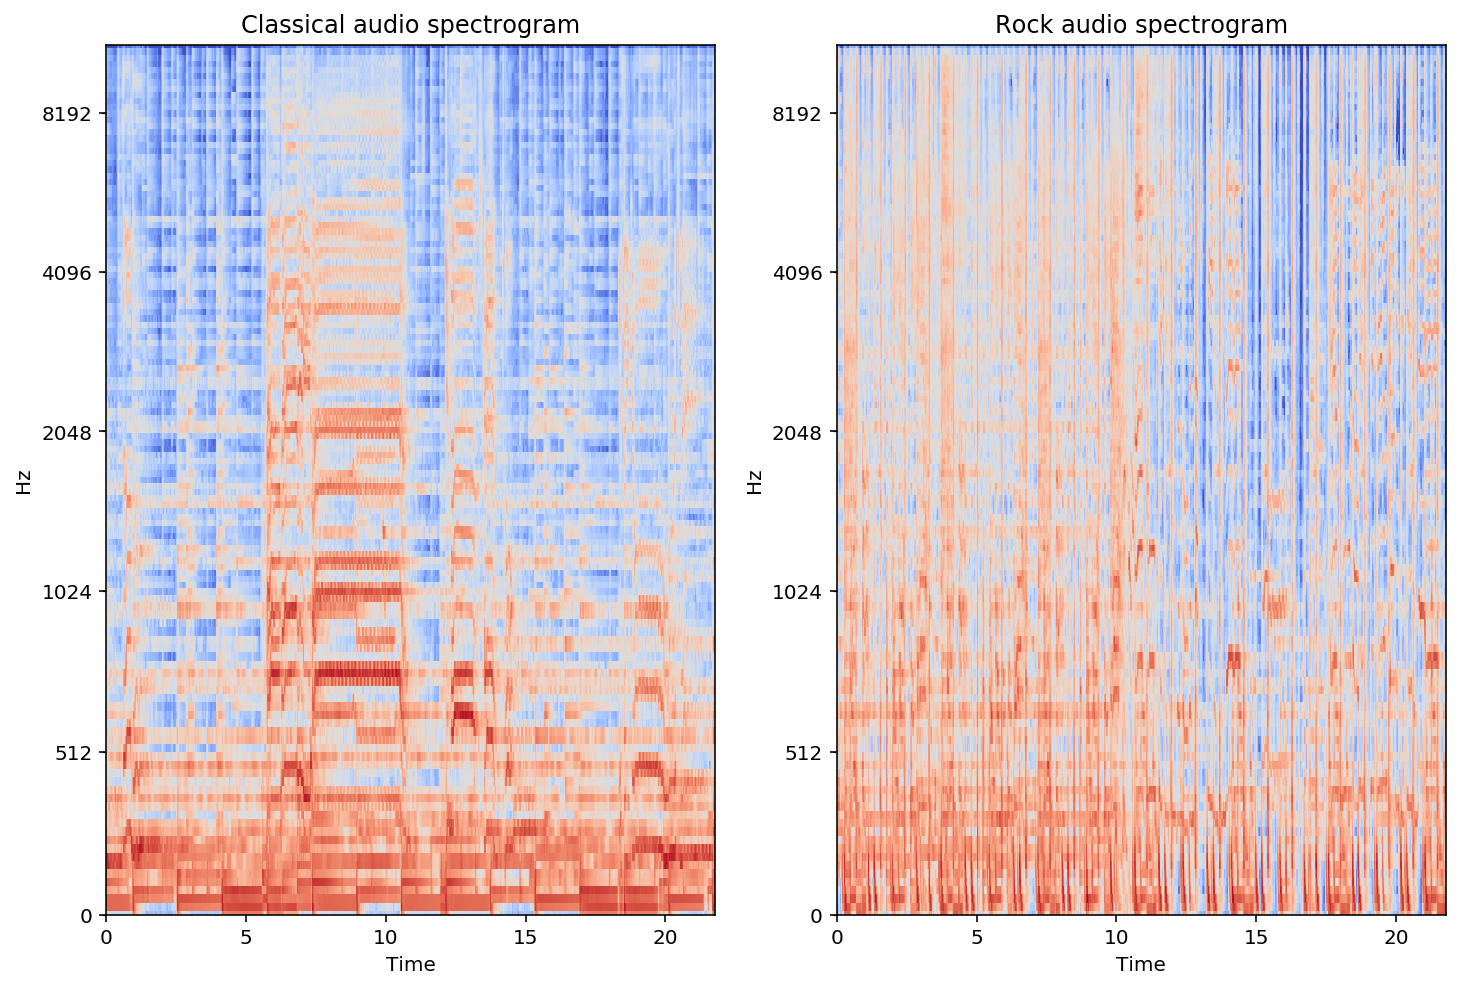

In [18]:
plt.subplot(121)
librosa.display.specshow(librosa.power_to_db(song_specs[302].T),
                          y_axis='mel',
                          x_axis='time',)
plt.title('Classical audio spectrogram')
plt.subplot(122)
librosa.display.specshow(librosa.power_to_db(song_specs[402].T),
                          y_axis='mel',
                          x_axis='time',)
plt.title('Rock audio spectrogram')

Text(0.5, 1.0, 'Classical audio spectrogram')

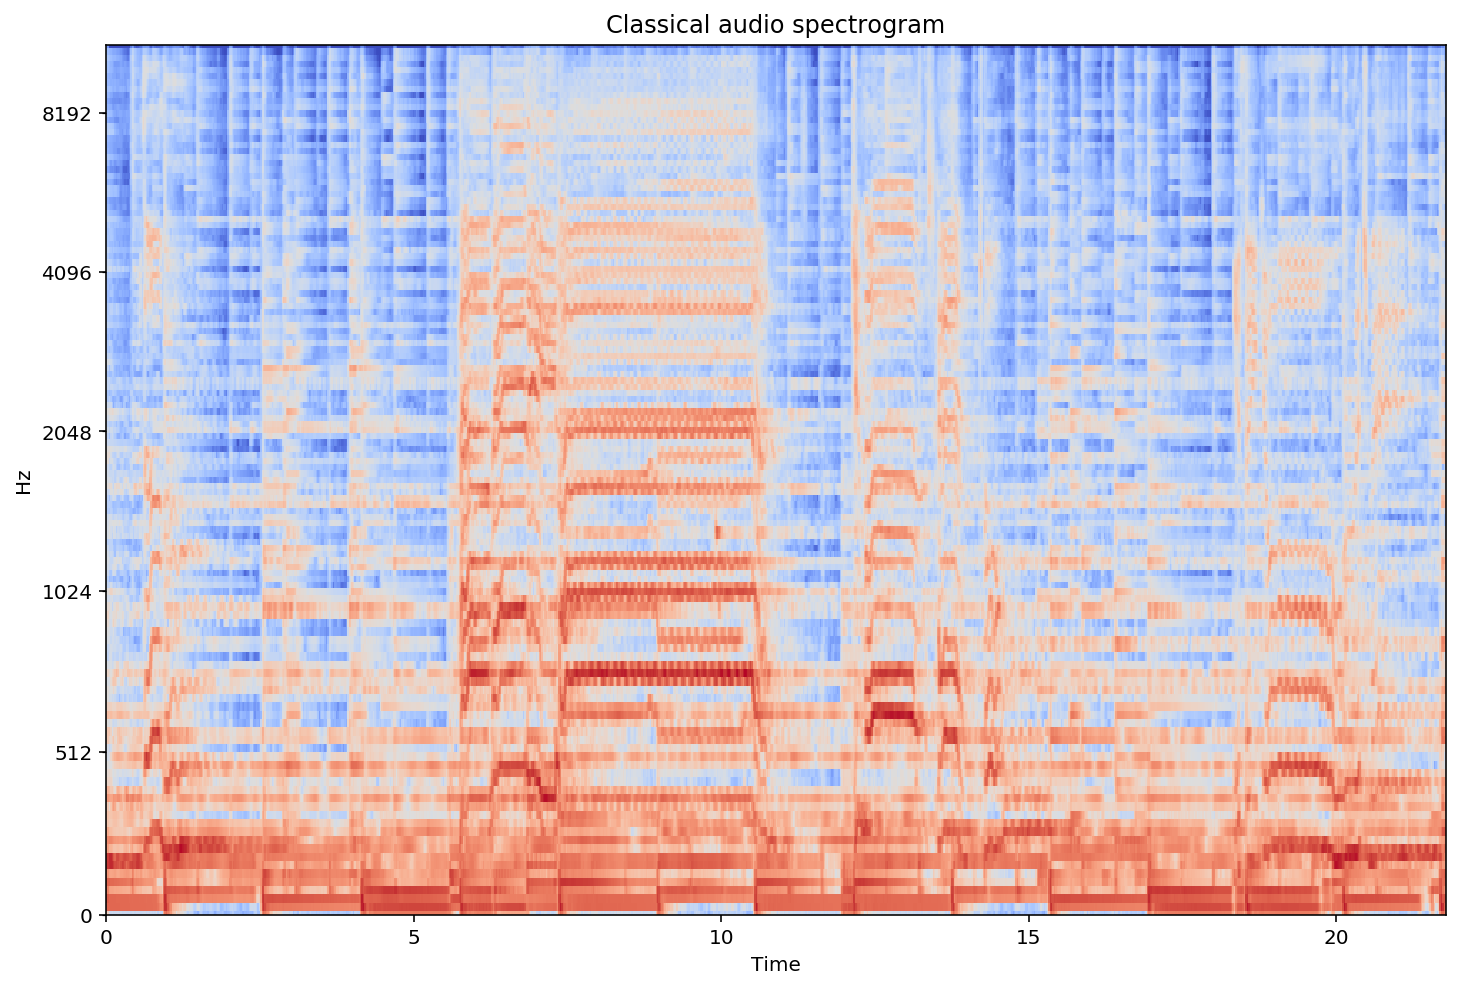

In [19]:
librosa.display.specshow(librosa.power_to_db(song_specs[302].T),
                          y_axis='mel',
                          x_axis='time',)
plt.title('Classical audio spectrogram')

In [0]:
song_specs = np.array(song_specs)

In [0]:
genre_one_hot = pd.get_dummies(genres)

In [22]:
song_specs.shape

(1000,)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(song_specs2, np.array(genre_one_hot),test_size=0.1,random_state = 42)

In [24]:
input_shape = (900, 128)
inputs = Input(input_shape)
x = inputs
levels = 64

for level in range(7):
    x = Conv1D(levels, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    levels *= 2

x = GlobalMaxPooling1D()(x)

for fc in range(2):
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

labels = Dense(10, activation='softmax')(x)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
model = Model(inputs=[inputs], outputs=[labels])
adam = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 900, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 898, 64)           24640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 898, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 449, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 447, 128)          24704     
_________________________________________________________________
batch_normalization_2 (Batch (None, 447, 128)          512       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 223, 128)          0   

In [27]:
x_train.shape

(900, 900, 128)

In [0]:
history = model.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      validation_data=(x_test, y_test))

In [0]:
from keras.models import Model
layer_name = 'dense_1'
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(song_specs2)

In [30]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_img_label = tsne_model.fit_transform(intermediate_output)
tsne_df = pd.DataFrame(tsne_img_label, columns=['x', 'y'])
tsne_df['image_label'] = genres

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.015s...
[t-SNE] Computed neighbors for 1000 samples in 0.517s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.836642
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.873871
[t-SNE] KL divergence after 1000 iterations: 0.714597


In [0]:
cat_id = tsne_df['image_label'].value_counts().reset_index().reset_index()
cat_id.columns = ['id','image_label','count']

In [0]:
tsne_df2 = pd.merge(tsne_df,cat_id,on='image_label')

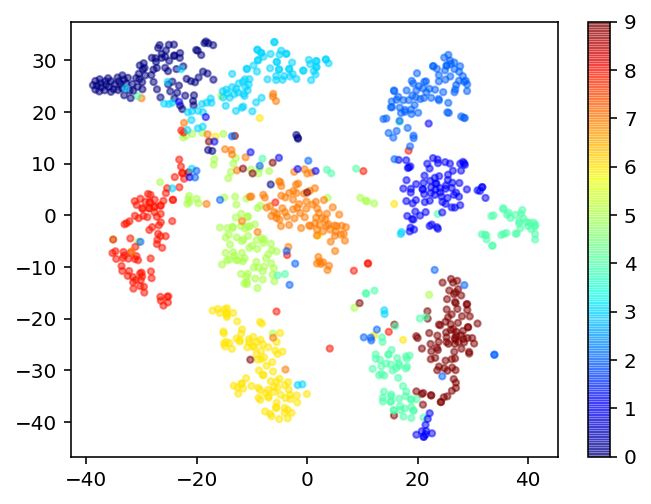

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
cmap = plt.cm.get_cmap('jet')
plt.scatter(tsne_df2['x'], tsne_df2['y'], 
            alpha=0.5, c=tsne_df2['id'], cmap=cmap, s=10)
plt.colorbar()